In [1]:
from django.conf import settings
settings.configure(BASE_DIR='/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska/djangoapp',)

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import sys
sys.path.append('/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska') 

In [2]:
from djangoapp.news.scripts.llm import *
from djangoapp.news.scripts.model_loader2 import *
from djangoapp.news.scripts.nlp import *

In [3]:
import pandas as pd
import pickle  
from tqdm.notebook import tqdm 

df = pd.read_csv('../all_datasets/data/merged_titles_labels.csv')

In [4]:
model_loader = ModelLoader()
llm = model_loader.llm 
vertex = model_loader.vertex
summarizer = model_loader.summarizer

## Testing Local LLM

In [5]:
df_test = pd.DataFrame() 
df_val2 = pd.DataFrame()

In [6]:
datasets_llm = dict()
for name in ['df_test', 'df_val2']:
    datasets_llm[name] = pd.DataFrame()

for dataset_name in datasets_llm.keys():
    # extract suffix after _
    dataset_name_suff = dataset_name.split('_')[1]
    file_name = f'llm_results_{dataset_name_suff}.csv'
    # check if file exists
    if os.path.isfile(file_name):
        print(f'Loading {file_name}...')
        datasets_llm[dataset_name] = pd.read_csv(file_name)
    else:
        datasets_llm[dataset_name] = df[df['sample'] == dataset_name_suff].reset_index(drop=True)

Loading llm_results_test.csv...
Loading llm_results_val2.csv...


In [7]:
import copy as cp
for dataset_name in datasets_llm.keys():
    if 'llm_pred' in datasets_llm[dataset_name].columns:
        print(f'{dataset_name} already predicted')
        continue
    print(f'Predicting {dataset_name}...')
    for i, row in tqdm(datasets_llm[dataset_name].iterrows(), total=datasets_llm[dataset_name].shape[0]):
        if row['title'] is not None:
            datasets_llm[dataset_name].loc[i, 'llm_pred'] = llm.predict(row['title'])
        else:
            datasets_llm[dataset_name].loc[i, 'llm_pred'] = None



df_test already predicted
df_val2 already predicted


In [8]:
for dataset_name in datasets_llm.keys():
    # extract suffix after _
    dataset = cp.deepcopy(datasets_llm[dataset_name])
    print(dataset.columns)
    dataset_name_suff = dataset_name.split('_')[1]
    file_name = f'llm_results_{dataset_name_suff}.csv'
    dataset[['title', 'is_clickbait', 'dataset', 'sample', 'llm_pred']].to_csv(file_name, index=False)
    print(f'Saved {file_name}...')

Index(['title', 'is_clickbait', 'dataset', 'sample', 'llm_pred'], dtype='object')
Saved llm_results_test.csv...
Index(['title', 'is_clickbait', 'dataset', 'sample', 'llm_pred'], dtype='object')
Saved llm_results_val2.csv...


In [9]:
df_test = datasets_llm['df_test']
df_val2 = datasets_llm['df_val2']
df_test.shape, df_val2.shape

((2590, 5), (1296, 5))

In [10]:
y_true = df_test['is_clickbait'].values
y_pred_proba = df_test['llm_pred'].values
y_pred = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'ROC AUC: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')



F1:          0.8193
ROC AUC:     0.9672
Recall:      0.7010
Precision:   0.9856
Accuracy:    0.8483


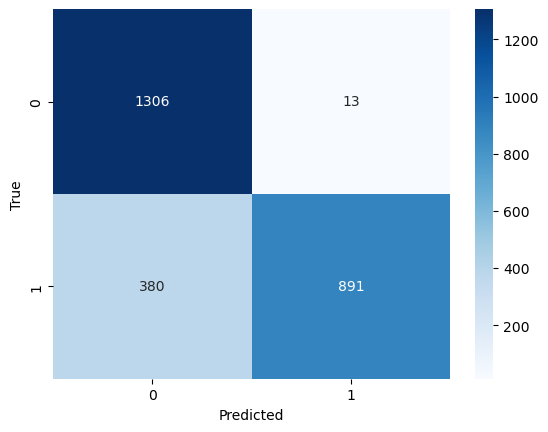

In [11]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
# find optimal threshold for F1 score
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

y_true_val = df_val2['is_clickbait'].values
y_pred_proba_val = df_val2['llm_pred'].values
n = 10000
thresholds = []
for i in tqdm(range(n)):
    threshold = i/n
    y_pred = (y_pred_proba_val > threshold).astype(int)
    thresholds.append((threshold, f1_score(y_true_val, y_pred)))
thresholds.sort(key=lambda x: x[1], reverse=True)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
print(thresholds[:1][0][0])

0.0031


In [14]:
y_pred = (y_pred_proba > thresholds[:1][0][0]).astype(int)

from sklearn.metrics import roc_auc_score, f1_score
print(f'F1 best F1 thresh: {f1_score(y_true, y_pred):>15.4f}')
print(f'ROC AUC best F1 thresh: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'Recall best F1 thresh: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision best F1 thresh: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy best F1 thresh: {accuracy_score(y_true, y_pred):>9.4f}')




F1 best F1 thresh:          0.9024
ROC AUC best F1 thresh:     0.9672
Recall best F1 thresh:      0.8914
Precision best F1 thresh:   0.9137
Accuracy best F1 thresh:    0.9054


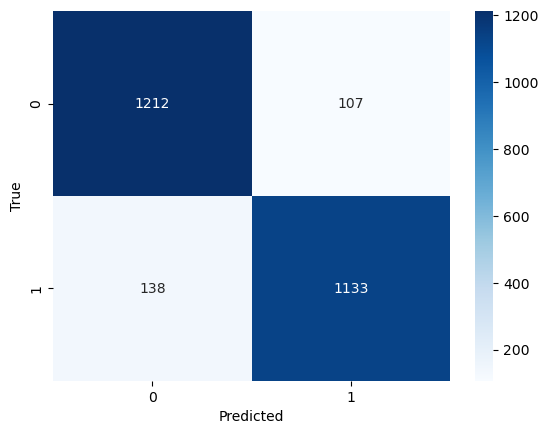

In [15]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Predykcja na zbiorze posiadającym niepuste wartości kolumny `text`

In [ ]:
df_test_vertex = pd.read_csv('vertex_results.csv')

#### Domyślny threshold

In [16]:
df_test = df_test[df_test_vertex['vertex_prediction_without_summary'].notnull()].reset_index(drop=True)
y_true = df_test['is_clickbait'].values
y_pred_proba = df_test['llm_pred'].values    

y_pred = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'ROC AUC: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')

KeyError: 'vertex_prediction_without_summary'

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Optymalny threshold dla F1

In [ ]:
y_pred = (y_pred_proba > thresholds[:1][0][0]).astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1 best F1 thresh: {f1_score(y_true, y_pred):>15.4f}')
print(f'ROC AUC best F1 thresh: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'Recall best F1 thresh: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision best F1 thresh: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy best F1 thresh: {accuracy_score(y_true, y_pred):>9.4f}')

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()